<a href="https://colab.research.google.com/github/susie682/Infosys722--Assignment-4-BDAS/blob/main/2_3_ExploreData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ========== 0) 环境 & 读取 ==========
!pip -q install pyspark==3.5.1

from google.colab import drive
drive.mount('/content/drive')

from pyspark.sql import SparkSession, functions as F, types as T
import pandas as pd
import numpy as np
import os, matplotlib.pyplot as plt




Mounted at /content/drive


In [2]:
spark = SparkSession.builder.appName("ChicagoCrime2017").getOrCreate()

# 修改为你的 CSV 在 Drive 的路径
FILE_PATH = "/content/drive/MyDrive/Infosys 722/CrimeData_2017.csv"

df = (spark.read
      .option("header", True)
      .option("inferSchema", True)
      .csv(FILE_PATH))

# 列名兜底（不同版本数据列名可能略有差异）
COL_DATE = "Date" if "Date" in df.columns else "ReportedDate"
COL_CAT  = "Primary Type" if "Primary Type" in df.columns else "PrimaryType"
COL_DIST = "District" if "District" in df.columns else "district"
COL_BEAT = "Beat" if "Beat" in df.columns else "beat"
COL_LAT  = "Latitude" if "Latitude" in df.columns else "latitude"
COL_LON  = "Longitude" if "Longitude" in df.columns else "longitude"

# 解析时间（兼容两种时间格式）
ts1 = F.to_timestamp(F.col(COL_DATE), "MM/dd/yyyy hh:mm:ss a")
ts2 = F.to_timestamp(F.col(COL_DATE), "MM/dd/yyyy HH:mm:ss")
df = df.withColumn("ts", F.coalesce(ts1, ts2))

# 基础类型修正
for bcol in ["Arrest","Domestic"]:
    if bcol in df.columns:
        df = df.withColumn(bcol, F.col(bcol).cast(T.BooleanType()))

# 时间衍生列
df = (df
      .withColumn("Year",  F.year("ts"))
      .withColumn("Month", F.month("ts"))
      .withColumn("Hour",  F.hour("ts"))
      .withColumn("WeekdayNum", F.dayofweek("ts")) # 1=Sun,...,7=Sat
      .withColumn("Weekday",
                  F.when(F.col("WeekdayNum")==2,"Monday")
                   .when(F.col("WeekdayNum")==3,"Tuesday")
                   .when(F.col("WeekdayNum")==4,"Wednesday")
                   .when(F.col("WeekdayNum")==5,"Thursday")
                   .when(F.col("WeekdayNum")==6,"Friday")
                   .when(F.col("WeekdayNum")==7,"Saturday")
                   .when(F.col("WeekdayNum")==1,"Sunday")
                   .otherwise("Unknown"))
     )

# 只取 2017（与你报告口径一致）
df2017 = df.filter(F.col("Year")==2017)

# 输出目录
os.makedirs("/content/figs", exist_ok=True)

# 统一的注数字体
plt.rcParams.update({"figure.dpi": 150})


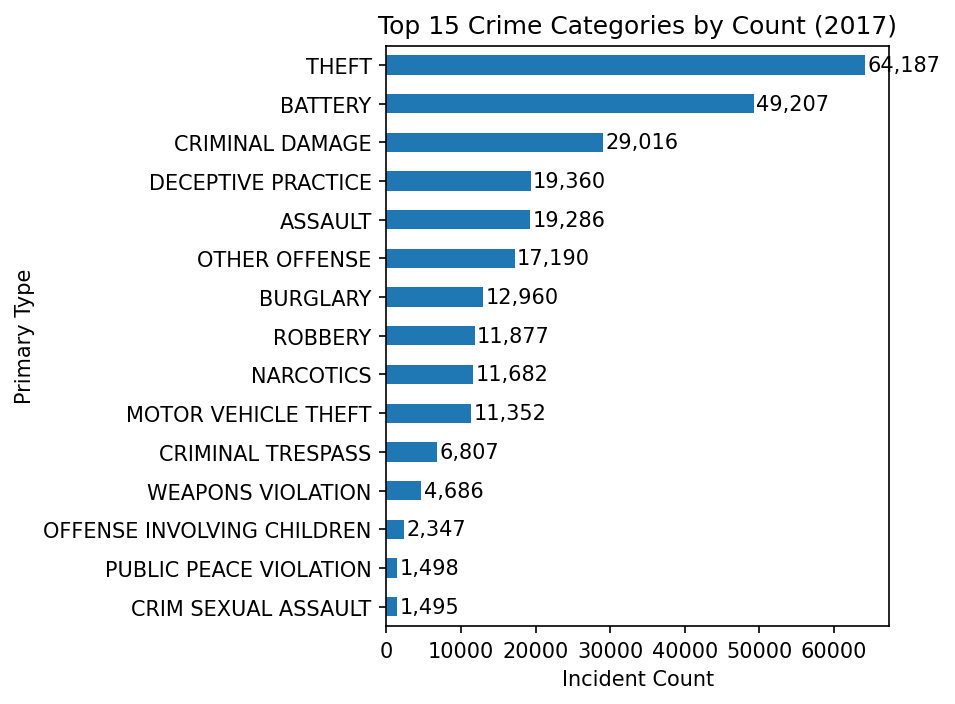

In [3]:
top_cat = (df2017.groupBy(F.col(COL_CAT)).count()
                  .orderBy(F.desc("count"))
                  .limit(15)).toPandas()

top_cat = top_cat.sort_values("count", ascending=True)

ax = top_cat.plot(kind="barh", x=COL_CAT, y="count", legend=False)
ax.set_title("Top 15 Crime Categories by Count (2017)")
ax.set_xlabel("Incident Count"); ax.set_ylabel("Primary Type")

# 注数值
for p in ax.patches:
    w = int(p.get_width())
    ax.text(w+300, p.get_y()+p.get_height()/2, f"{w:,}", va="center")

plt.tight_layout()
plt.savefig("/content/figs/figure5_primary_type_by_count.png")
plt.show()
